Redes bayesianas - Miguel Madueño Sanz

In [2]:
library(gRain)
library(bnlearn)

**Ejercicio 1 (2.5 Puntos)**

    - A partir del grafo dado por el experto, determina la expresión que refleja la factorización de la distribución global, y escríbela como una secuencia de caracteres del tipo generado por la función modelstring del paquete de R bnlearn.

NOTA: Como ya se comentado anteriormente, es importante evitar tildes a la hora de nombrar los nodos. Tampoco son recomendables espacios en blanco ni ningún tipo de carácter especial.

    - A continuación, introduce el DAG en R utilizando la definicíon del modelo que acabas de crear

    - Realiza una lista de los padres e hijos de cada uno de los nodos

    - Realiza una lista de todas las conexiones fundamentales presentes en el grafo, y realiza una clasificación de cada una de ellas determinando si es una estructura en serie, divergente o convergente.

    - ¿Se observa alguna v-estructura en el grafo?

    - Intenta introducir un arco que parta del nodo neblina y se dirija hacia escarcha, y otro que vaya de granizo a lluvia. Comenta qué sucede en cada caso, y si el resultado daría lugar a una red bayesiana válida.

    - Determina la manta de Markov del nodo rocio

    - Introduce un arco que parta del nodo Lluvia y se dirija al nodo Niebla, ¿cambia la manta de Markov del nodo rocio? En caso afirmativo, ¿cómo lo hace?

Para continuar, elimina el arco definido anteriormente entre los nodos Lluvia y Niebla, recuperando el DAG original.

In [3]:
#expresión de la distribución global
string <- '[viento][rocio|viento][lluvia|viento][tormenta|lluvia][neblina|niebla][granizo|tormenta][nieve|tormenta][escarcha|rocio][niebla|viento:rocio][nieveSuelo|nieve]'

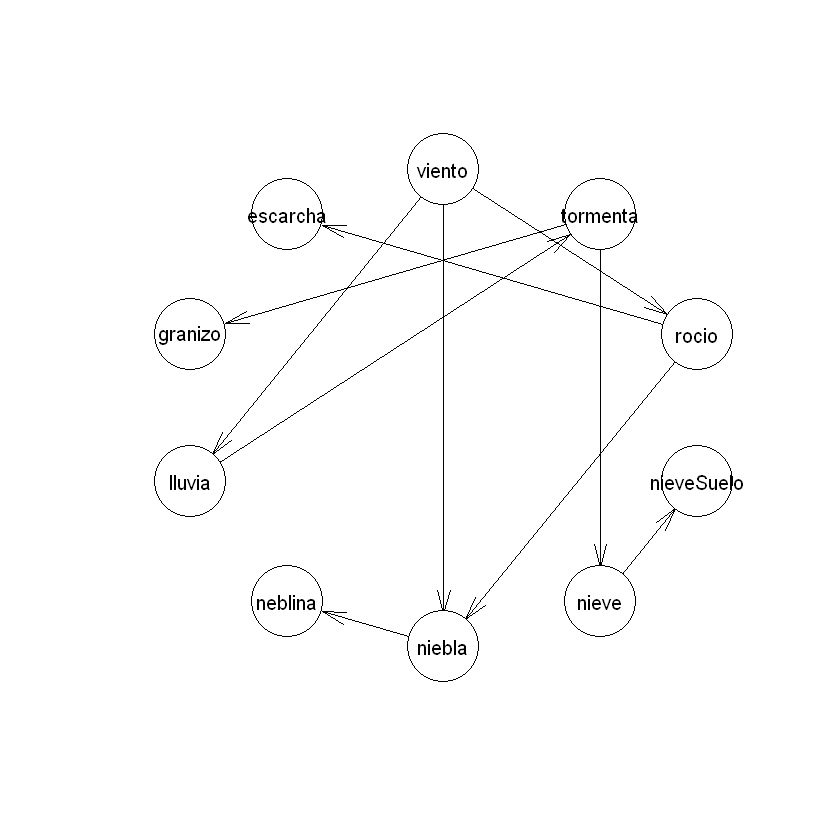

In [4]:
#dag
dag <- model2network(string)
plot(dag)

In [5]:
#padres e hijos por nodo
tablaParent <- data.frame(
    Nodo = character(),
    Padres = character(),
    Hijos = character(),
    stringsAsFactors = FALSE
)

In [6]:
for (nodo in nodes(dag)) {
    hijos <- ifelse(length(bnlearn::children(dag, nodo))==0, NA, paste(bnlearn::children(dag, nodo), collapse = ", "))
    padres <- ifelse(length(bnlearn::parents(dag, nodo))==0, NA, paste(bnlearn::parents(dag, nodo), collapse = ", "))
    
    tablaParent[nrow(tablaParent)+1,] = c(nodo, padres, hijos)
}
tablaParent

,Nodo,Padres,Hijos
,<chr>,<chr>,<chr>
1,escarcha,rocio,NA
2,granizo,tormenta,NA
3,lluvia,viento,tormenta
4,neblina,niebla,NA
5,niebla,"rocio, viento",neblina
6,nieve,tormenta,nieveSuelo
7,nieveSuelo,nieve,NA
8,rocio,viento,"escarcha, niebla"
9,tormenta,lluvia,"granizo, nieve"


In [7]:
#conexiones fundamentales y clasificación según su tipo. Recorremos los nodos del grafo y hacemos estructuras 
#combinando sus padres e hijos siempre que sea posible

#estructuras de la forma A---X---B. En caso de que sean en serie, se coloca el padre a la izquierda.

tablaConex <- data.frame(
    A = character(),
    X = character(),
    B = character(),
    tipo = character(),
    stringsAsFactors = FALSE
)

for (nodo in nodes(dag)) {
    hijos <- bnlearn::children(dag, nodo)
    padres <- bnlearn::parents(dag, nodo)

    familiares <- union(padres,hijos)

    #compruebo si hay estructuras de 3
    if(length(familiares)>1){
        #calculo las posibles combinaciones
        combinations <- combn(familiares, 2)
        for(c in 1:dim(combinations)[2]){
            a <- combinations[1,c]
            b <- combinations[2,c]
            if (is.element(a,padres)){
                if(is.element(b,padres)){
                    tablaConex[nrow(tablaConex)+1,] = c(a, nodo, b, 'convergente')
                }else{
                    tablaConex[nrow(tablaConex)+1,] = c(a, nodo, b, 'enSerie')
                }
            }else{
                if(is.element(b,padres)){
                    tablaConex[nrow(tablaConex)+1,] = c(b, nodo, a, 'enSerie')
                }else{
                    tablaConex[nrow(tablaConex)+1,] = c(a, nodo, b, 'divergente')
                }
            }     
        }         
    }  
}
tablaConex

,A,X,B,tipo
,<chr>,<chr>,<chr>,<chr>
1,viento,lluvia,tormenta,enSerie
2,rocio,niebla,viento,convergente
3,rocio,niebla,neblina,enSerie
4,viento,niebla,neblina,enSerie
5,tormenta,nieve,nieveSuelo,enSerie
6,viento,rocio,escarcha,enSerie
7,viento,rocio,niebla,enSerie
8,escarcha,rocio,niebla,divergente
9,lluvia,tormenta,granizo,enSerie


In [8]:
#no hay v-estructuras
vstructs(dag)

X,Z,Y


In [9]:
#introducir nuevos arcos
dag <- set.arc(dag, from = "neblina", to = "escarcha") 

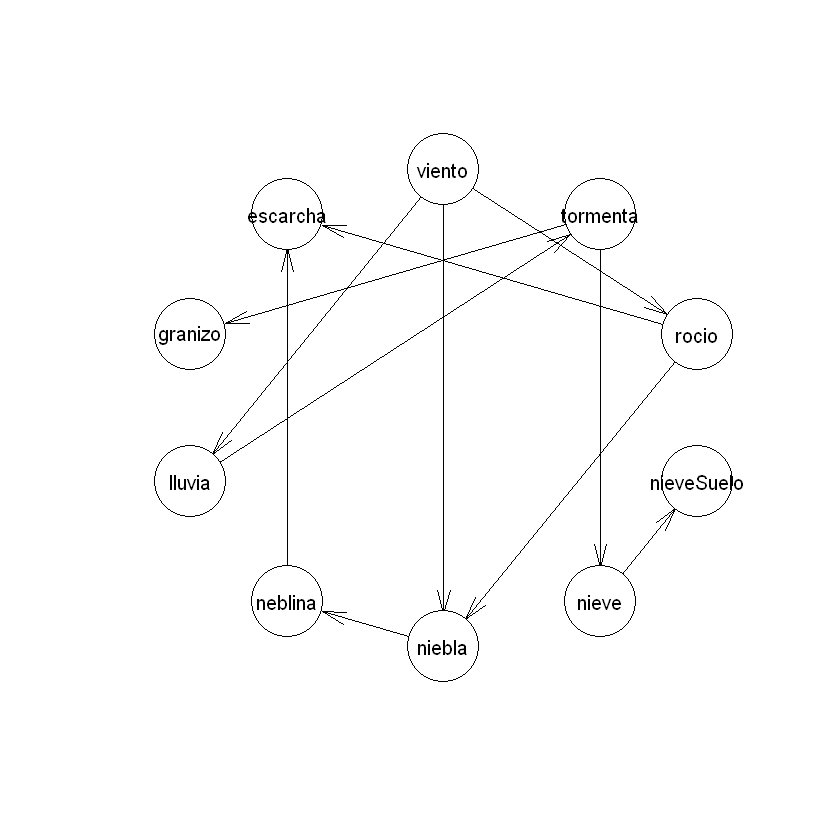

In [10]:
plot(dag)

Se ejecuta el código sin problemas y se obtiene una red bayesiana válida.

In [11]:
dag <- set.arc(dag, from = "granizo", to = "lluvia") 

ERROR: Error in arc.operations(x = x, from = from, to = to, op = "set", check.cycles = check.cycles, : the resulting graph contains cycles.


No se ejecuta el código porque este arco introduce un ciclo cerrado en la red y la función set.arc evita este tipo de configuraciones, ya que forman redes que no son válidas.

In [12]:
#manta de Markov del nodo Rocio, que coincide con el conjunto de sus padres, hijos, y padres de sus hijos. 
mb(dag, "rocio")

[1] "escarcha" "neblina"  "niebla"   "viento"

In [13]:
dag <- set.arc(dag, from = "lluvia", to = "niebla") 

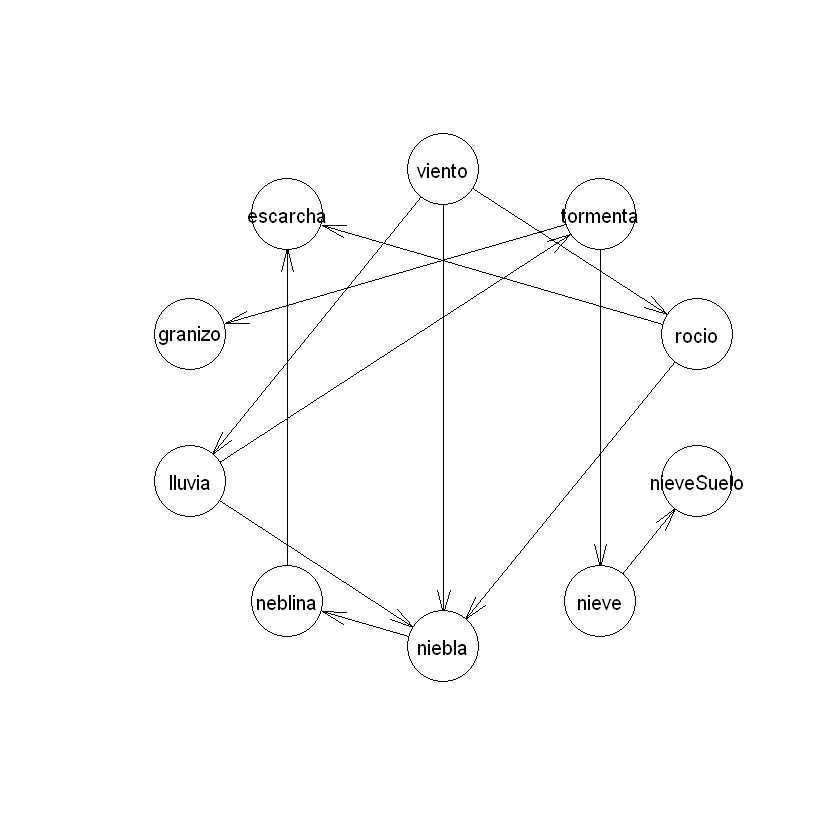

In [14]:
plot(dag)

In [15]:
mb(dag, "rocio")

[1] "escarcha" "lluvia"   "neblina"  "niebla"   "viento"

Se añade el nodo Lluvia, ya que es padre de un hijo de Rocio, Niebla.

In [16]:
#recuperamos dag original: eliminar neblina --> escarcha y lluvia --> niebla

dag <- drop.arc(dag, from = "lluvia", to = "niebla") 
dag <- drop.arc(dag, from = "neblina", to = "escarcha") 

**Ejercicio 2 (2.5 Puntos)**

    - Considerando la información proporcionada por el conjunto de datos meteor, construye la red bayesiana utilizando el método bayesiano de estimación paramétrica.

    - ¿Cuál sería el número potencial de parámetros (sin usar la red bayesiana) del modelo para calcular la probabilidad global si no utilizasemos el DAG?

    - ¿Cuántos parámetros tiene la distribución global dada por la red bayesiana?

    - Determina el número de parámetros asociado a cada una de las distribuciones locales

    - Obtén las tablas de probabilidad condicional asociadas los nodos granizo y niebla. Ahora representa la información de cada tabla en sendos gráficos.


In [17]:
#BN con estimación parametrica
df <- read.table("meteoro.txt", header = TRUE, stringsAsFactors = TRUE)
head(df)

,lluvia,nieve,granizo,tormenta,niebla,rocio,escarcha,nieveSuelo,neblina,viento
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,s,n,n,n,n,n,n,n,n,s
2,s,n,n,n,n,n,n,n,n,s
3,s,n,n,s,n,n,n,n,n,s
4,s,n,n,n,n,n,n,n,n,s
5,s,n,s,s,n,n,n,n,n,s
6,s,n,s,s,n,n,n,n,n,s


In [18]:
bred <- bn.fit(dag, data = df, method = "bayes")
class(bred)

[1] "bn.fit"      "bn.fit.dnet"

In [19]:
# numero de parametros del modelo sin el dag = 
# = numero de valores de la probabilidad -1 = numero de combinaciones de estados -1 = 
2**10-1

[1] 1023

Cálculo del número de parámetros correspondiente a un nodo, $numPar$: suponemos que el nodo puede tomar n valores diferentes, y que tiene m padres, cada uno de los cuales puede tomar k_i, i=1,...,m valores. Para una combinación concreta de los estados de los nodos padre, el nodo hijo tiene asociada una distribución de probabilidad concreta, y basta conocer su valor en n-1 estados del nodo para determinarla, ya que la probabilidad del último estado se obtiene sabiendo que la probabilidad del total de estados es 1. Por tanto, recorriendo todas las combinaciones de valores de los padres, se puede calcular el número de parámetros correspondientes al nodo seleccionado, siendo la expresión: 

$numPar = (n-1) \cdot k_1 \cdot ~...~ \cdot k_m$

In [20]:
#parametros de la distribucion de la red bayesiana
numpar <- 0
for (n in nodes(bred)){
    dimensiones <- dim(bred[[n]]$prob)
    dimensiones[1] <- dimensiones[1]-1
    numpar <- numpar + prod(dimensiones)  
}
numpar

[1] 21

In [21]:
#numero de parametros de las distribuciones de cada nodo
i <- 1
df_local <- data.frame(
    Nodo = character(),
    NumParam = character(),
    stringsAsFactors = FALSE
)

for (n in nodes(bred)){
    df_local[nrow(df_local)+1,] <- c(n, prod(dim(bred[[n]]$prob)))
    i <- i+1
}

df_local

,Nodo,NumParam
,<chr>,<chr>
1,escarcha,4
2,granizo,4
3,lluvia,4
4,neblina,4
5,niebla,8
6,nieve,4
7,nieveSuelo,4
8,rocio,4
9,tormenta,4


In [22]:
#visualizamos las tablas de probabilidad condicional para granizo y niebla

#granizo
bred$granizo$prob

       tormenta
granizo           n           s
      n 0.990183352 0.745742092
      s 0.009816648 0.254257908

In [23]:
#niebla
bred$niebla$prob

, , viento = n

      rocio
niebla           n           s
     n 0.946399802 0.855234203
     s 0.053600198 0.144765797

, , viento = s

      rocio
niebla           n           s
     n 0.995195025 0.934108527
     s 0.004804975 0.065891473


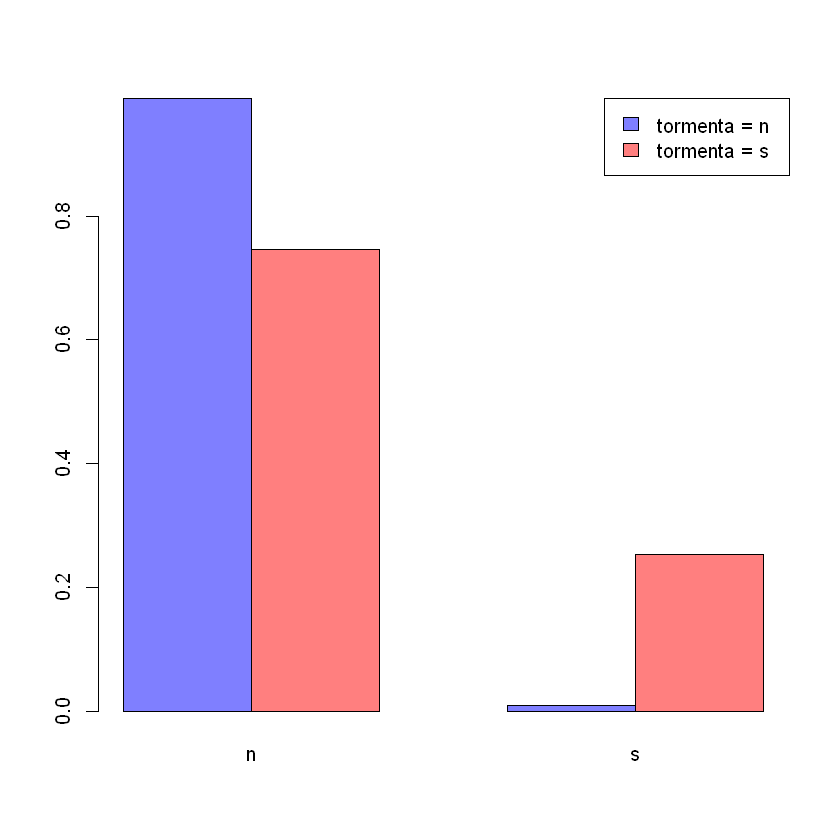

In [24]:
#densidad de probabiliddad de granizo
barplot(t(bred$granizo$prob), beside=TRUE, col =  c(rgb(0, 0, 1, 0.5), rgb(1, 0, 0, 0.5)))
legend("topright", legend = c("tormenta = n", "tormenta = s"), fill = c(rgb(0, 0, 1, 0.5), rgb(1, 0, 0, 0.5)))

Vemos que los días de granizo son pocos, y que, cuando se dan, por lo general hay tormenta.

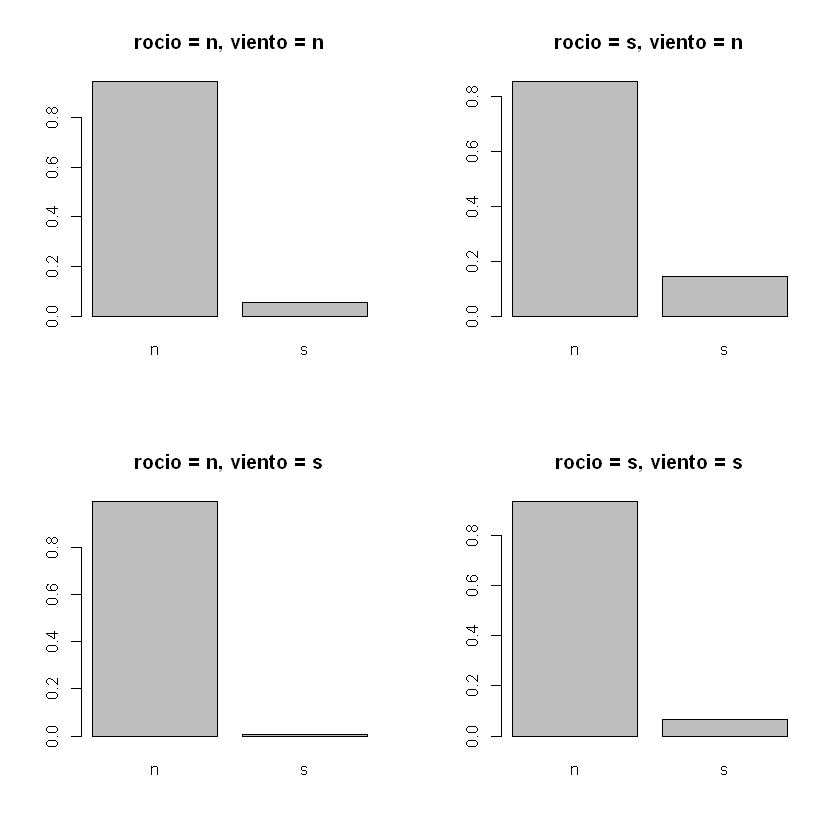

In [25]:
#densidades de probabilidad de niebla
par(mfrow = c(2, 2))

barplot(bred$niebla$prob[,1,1], main = 'rocio = n, viento = n')
barplot(bred$niebla$prob[,2,1], main = 'rocio = s, viento = n')
barplot(bred$niebla$prob[,1,2], main = 'rocio = n, viento = s')
barplot(bred$niebla$prob[,2,2], main = 'rocio = s, viento = s')

Estas tablas pueden ser calculadas también con las frecuencias empíricas de cada variable

In [26]:
estados <- c("n", "s")
n <- length(df$viento)

In [27]:

granizo.prob <- array(c(length(which(df$granizo == 'n' & df$tormenta == 'n'))/length(which(df$tormenta == 'n')),
                       length(which(df$granizo == 's' & df$tormenta == 'n'))/length(which(df$tormenta == 'n')),
                       length(which(df$granizo == 'n' & df$tormenta == 's'))/length(which(df$tormenta == 's')),
                       length(which(df$granizo == 's' & df$tormenta == 's'))/length(which(df$tormenta == 's'))), dim = c(2,2), 
                     dimnames = list(granizo = estados, tormenta = estados))


niebla.prob <- array(c(length(which(df$niebla == 'n' & df$rocio == 'n' & df$viento == 'n'))/length(which(df$rocio == 'n' & df$viento == 'n')),
                     length(which(df$niebla == 's' & df$rocio == 'n' & df$viento == 'n'))/length(which(df$rocio == 'n' & df$viento == 'n')),
                     length(which(df$niebla == 'n' & df$rocio == 's' & df$viento == 'n'))/length(which(df$rocio == 's' & df$viento == 'n')),
                     length(which(df$niebla == 's' & df$rocio == 's' & df$viento == 'n'))/length(which(df$rocio == 's' & df$viento == 'n')),
                     length(which(df$niebla == 'n' & df$rocio == 'n' & df$viento == 's'))/length(which(df$rocio == 'n' & df$viento == 's')),
                     length(which(df$niebla == 's' & df$rocio == 'n' & df$viento == 's'))/length(which(df$rocio == 'n' & df$viento == 's')),
                     length(which(df$niebla == 'n' & df$rocio == 's' & df$viento == 's'))/length(which(df$rocio == 's' & df$viento == 's')),
                     length(which(df$niebla == 's' & df$rocio == 's' & df$viento == 's'))/length(which(df$rocio == 's' & df$viento == 's'))), dim = c(2,2,2), 
                  dimnames = list(niebla = estados, rocio = estados, viento = estados))

In [28]:
granizo.prob

,n,s
n,0.990262902,0.7463415
s,0.009737098,0.2536585


In [29]:
niebla.prob[,,1]

,n,s
n,0.94645513,0.8553459
s,0.05354487,0.1446541


In [30]:
niebla.prob[,,2]

,n,s
n,0.995475113,0.9375
s,0.004524887,0.0625


Vemos que se obtienen aproximadamente las mismas probabilidades, aunque los valores difieran un poco.

**Ejercicio 3 (2.5 Puntos)**

Una vez construída la red hemos establecido la base de conocimiento del sistema inteligente. A continuación se puede calcular la probabilidad de cualquier variable o conjunto de variables condicionadas a cualquier evidencia que se tenga disponible para un problema dado, es decir, realizar la inferencia.

    - Observa la estructura del DAG y repasa la teoría y el concepto de d-separación. Responde razonadamente si las siguientes afirmaciones son verdaderas o falsas, utilizando únicamente la estructura del DAG y el concepto de d-separación:

        La nieve y el granizo son fenómenos independientes a priori
        
        La nieve y el granizo son fenómenos independientes dado que haya habido tormenta
        
        La nieve en el suelo y la neblina son fenómenos independientes
        
        La nieve en el suelo y la neblina son fenómenos independientes dado que haya habido tormenta

    - NOTA: En este apartado se deberá aplicar la inferencia exacta. Conocido que en un día dado se han producido tormentas, calcula cómo afecta este hecho a la probabilidad de que se produzcan los siguientes fenómenos meteorológicos:

        Que llueva, P(lluvia=s|tormenta=s)
        
        Que haya rachas de viento superiores a 50 Km/h, P(viento=s|tormenta=s)
        
        Que llueva y que además las rachas de viento superen los 50 Km/h, P(lluvia=s,viento=n|tormenta=s)
        
        A partir de la información revelada por la red bayesiana, sabiendo que un día se producen tormentas:  
    
            * ¿Hay mayor probabilidad de que llueva cuando se producen tormentas que cualquier otro día?
            * ¿Aumenta o disminuye la probabilidad de tener rachas de viento mayores de 50 Km/h cuando se produce tormenta? ¿Cuánto?    
    
    
    - Dado el ejercicio anterior, repetir ahora el ejercicio mediante inferencia aproximada, calculando para cada una de las estimaciones 100 realizaciones. Para cada una de las respuestas anteriores, representa un diagrama de cajas que represente la dispersión en la estimación de la probabilidad, marcando además el valor obtenido de manera exacta en el apartado anterior.

In [31]:
#verdadero o falso:

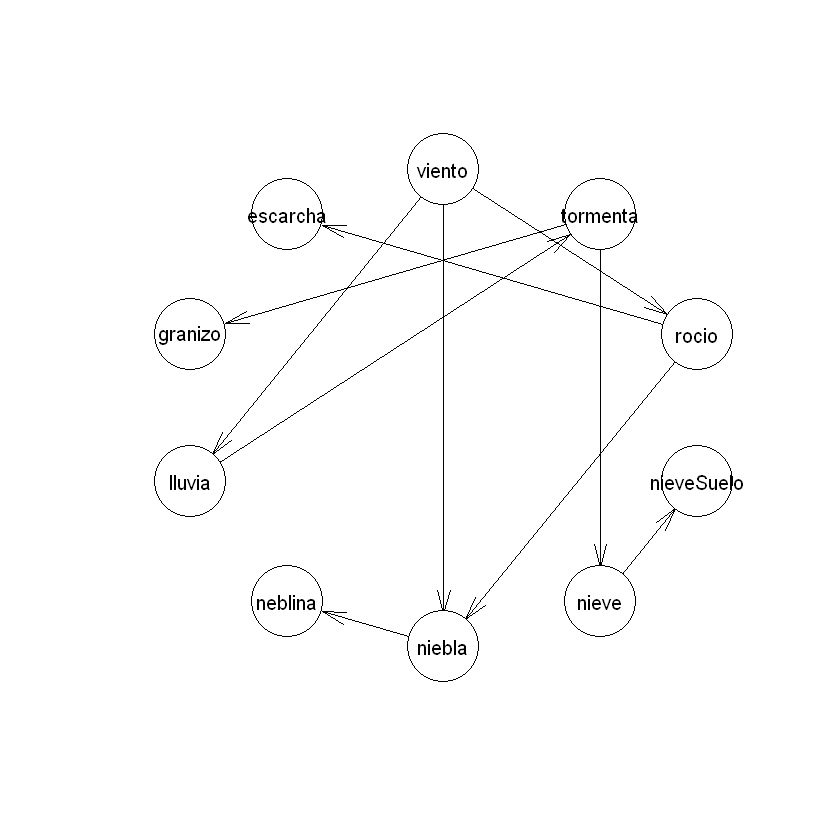

In [32]:
plot(dag)

* La nieve y el granizo son fenómenos independientes a priori. Falso: el camino nieve-tormenta-granizo los relaciona.

* La nieve y el granizo son fenómenos independientes dado que haya habido tormenta. Verdadero. Nieve y granizo están d-separados porque forman una estructura divergente con tormenta y el valor de esta última se conoce.

* La nieve en el suelo y la neblina son fenómenos independientes. Falso. Hay un camino que los une: nieveSuelo-nieve-tormenta-lluvia-viento-niebla-neblina.

* La nieve en el suelo y la neblina son fenómenos independientes dado que haya habido tormenta. Verdadero. Están d-separados conocido el valor de tormenta ya que solo hay dos caminos que unen nieveSuelo con neblina y los dos pasan por tormenta.

In [33]:
#calculo de probabilidades con inferencia exacta

#probabilidades marginales
arbol <- compile(as.grain(bred))

In [34]:
#probabilidad marginal de que llueva
lluvia.marg <-querygrain(arbol, nodes = "lluvia")$lluvia[2]
lluvia.marg

s 
0.5556739

In [35]:
#probabilidad marginal de que haya rachas de viento
viento.marg <- querygrain(arbol, nodes = "viento")$viento[2]
viento.marg

s 
0.1443566

In [36]:
#probabilidad marginal de que haya rachas de viento y llueva
lluviayviento.marg <-querygrain(arbol, nodes = c("lluvia",'viento'), type = 'joint')[2,2]
lluviayviento.marg

[1] 0.1245056

In [37]:
#probabilidades condicionadas a tormenta = s

arbolT <- setEvidence(arbol, nodes = "tormenta", states = "s")

In [38]:
#probabilidad de que llueva condicionada a que haya tormenta
lluvia.cond <- querygrain(arbolT, nodes = "lluvia")$lluvia[2]
lluvia.cond

s 
0.959854

In [39]:
#probabilidad de que haya rachas de viento condicionada a que haya tormenta
viento.cond <- querygrain(arbolT, nodes = "viento")$viento[2]
viento.cond 

s 
0.2168608

In [40]:
#probabilidad de que haya rachas de viento y llueva cuando hay tormenta
lluviayviento.cond <- querygrain(arbolT, nodes = c("lluvia",'viento'), type = 'joint')[2,2]
lluviayviento.cond

[1] 0.2150672

In [41]:
#comparacion
lluvia.cond/lluvia.marg

s 
1.727369

In [42]:
viento.cond/viento.marg

s 
1.502258

In [43]:
lluviayviento.cond/lluviayviento.marg

[1] 1.727369

Al tener en cuenta el efecto de que haya tormenta en la probabilidad de lluvia y/o viento, vemos que tanto en los casos de lluvia o viento por separado como en la combinación de lluvia y viento, el hecho de haber tormenta aumenta la probabilidad de que se produzcan estos fenómenos en comparación con los casos marginales.



In [44]:
#calculo de probabilidades con inferencia aproximada
set.seed(1)

v.aprox <- vector("numeric", length = 100)
ll.aprox <- vector("numeric", length = 100)
llyv.aprox <- vector("numeric", length = 100)
v.marg.aprox <- vector("numeric", length = 100)
ll.marg.aprox <- vector("numeric", length = 100)
llyv.marg.aprox <- vector("numeric", length = 100)

set.seed(1)
for(i in 1:100){
    v.aprox[i] <- cpquery(bred, event = (viento == "s"), evidence = (tormenta == "s"))
    ll.aprox[i] <- cpquery(bred, event = (lluvia == "s"), evidence = (tormenta == "s"))
    llyv.aprox[i] <- cpquery(bred, event = (viento == "s") & (lluvia == "s"), evidence = (tormenta == "s"))
    v.marg.aprox[i] <- cpquery(bred, event = (viento == "s"), evidence = TRUE)
    ll.marg.aprox[i] <- cpquery(bred, event = (lluvia == "s"), evidence = TRUE)
    llyv.marg.aprox[i] <- cpquery(bred, event = (viento == "s") & (lluvia == "s"), evidence = TRUE)
}

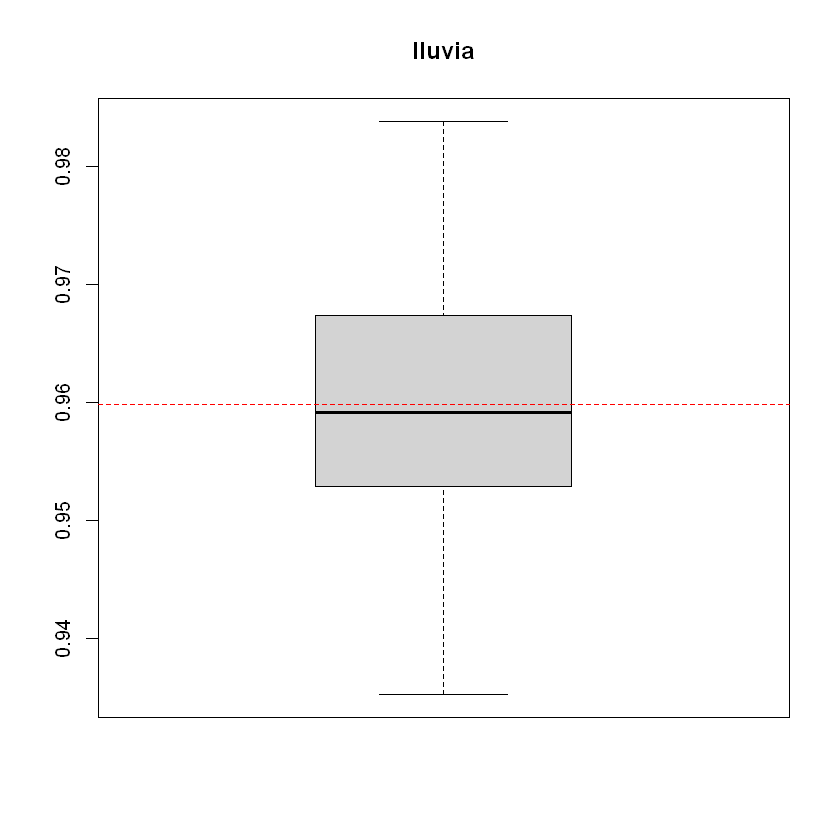

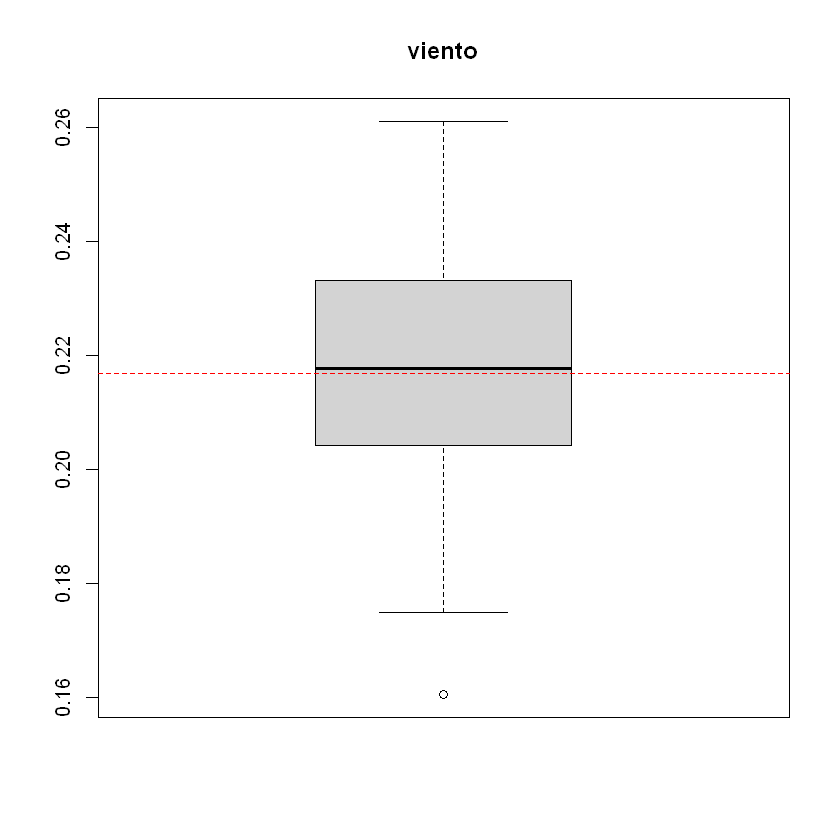

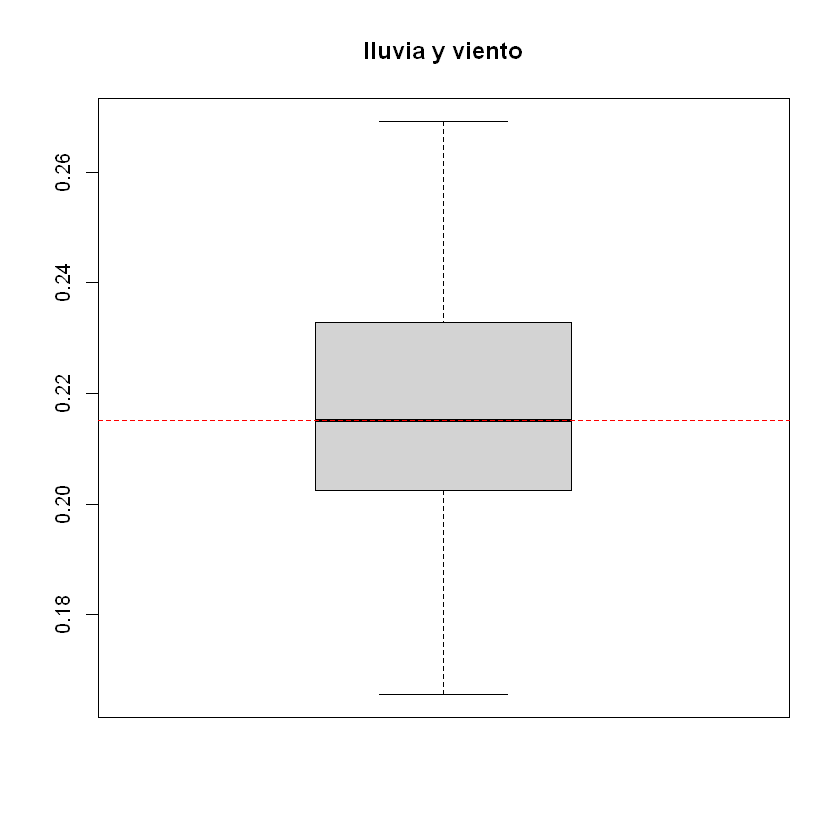

In [45]:
#boxplot probabilidad de fenomenos condicionados a tormenta = 's'

boxplot(ll.aprox, main = 'lluvia')
abline(h = lluvia.cond, col = "red", lty = 2)

boxplot(v.aprox, main = 'viento')
abline(h = viento.cond, col = "red", lty = 2)

boxplot(llyv.aprox, main = 'lluvia y viento')
abline(h = lluviayviento.cond, col = "red", lty = 2)

Se observa que para las probabilidades condicionadas calculadas por inferencia aproximada, el valor mediano aproxima bastante bien el calculado por inferencia exacta. Además, los percentiles 5 y 95 se alejan poco de la mediana, especialmente en el caso de lluvia, donde la desviación está en torno al 2 \%.

In [79]:
#comparacion de resultados obtenidos con inferencia exacta y a proximada
probComp <- data.frame(
     ll = c(unname(lluvia.marg),mean(ll.marg.aprox)),
     v = c(unname(viento.marg),mean(v.marg.aprox)),
     llyv = c(unname(lluviayviento.marg),mean(llyv.marg.aprox)),
     ll.cond = c(unname(lluvia.cond),mean(ll.aprox)),
     v.cond = c(unname(viento.cond),mean(v.aprox)),
     llyv.cond = c(unname(lluviayviento.cond),mean(llyv.aprox))    
)

row.names(probComp) <- c('inf.exacta','inf.aprox.')
probComp

,ll,v,llyv,ll.cond,v.cond,llyv.cond
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
inf.exacta,0.5556739,0.1443566,0.1245056,0.9598540,0.2168608,0.2150672
inf.aprox.,0.5548340,0.1448360,0.1243900,0.9598238,0.2182872,0.2173832


Comprobamos que las estimaciones de las probabilidadas dadas por ambos métodos son muy parecidas.

In [80]:
#por último, comparamos las probabilidades marginales y condicionadas de cada variable 
#para el cálculo con inferenica aproximada

#lluvia
mean(ll.aprox)/mean(ll.marg.aprox)

[1] 1.72993

In [81]:
#viento
mean(v.aprox)/mean(v.marg.aprox)

[1] 1.507134

In [82]:
#viento y lluvia
mean(llyv.aprox)/mean(llyv.marg.aprox)

[1] 1.747594

De la misma forma que en el apartado anterior, observamos que la inferencia aproximada sigue estimando que la ocurrencia de tormenta tiene un efecto positivo en el evento de lluvia, de viento, y de lluvia y viento conjuntos.

**Ejercicio 4 (2.5 Puntos)**

Como hemos visto, es posible realizar un aprendizaje automático de la estructura del DAG a partir de los datos, usando algoritmos específicos para ello. Durante las clases hemos visto el ejemplo del algoritmo hill-climbing, aunque como vimos, hay otras posibilidades. Tambien hemos visto que podemos combinar nuestra experiencia y el aprendizaje automático definiendo previamente relaciones entre variables que queremos introducir o descartar en el DAG resultante. Además, se ha explicado que existen scores que sirven como criterio para evaluar la fuerza de la dependendencia entre nodos de la red y comparar la bondad de ajuste del modelo.

    - Evalúa la significación de los arcos dibujados por el experto en el actual DAG utilizando el estadístico χ2 . ¿Hay algún arco no significativo? ¿Cuáles son los tres pares de nodos que presentan un arco de unión más fuerte?

    - Además del algoritmo hill-climbing, existe otro algoritmo popular de tipo “voraz” denominado Tabu search. En bnlearn se encuentra implementado a traves de la función tabu, y los argumentos de entrada son similares a los vistos para hill-climbing.

        Compara el score global (BIC) obtenido por el DAG inicial, con los obtenidos por los DAG aprendidos de forma automática con los algoritmos tabu y hill-climbing. ¿Cuál obtiene mejor score?
        
        Ahora, para comparar el DAG original con los dos nuevos DAG tabu y hill-climbing, dibuja los tres utilizando la función graphviz.plot. A la luz de los grafos obtenidos en cada caso, ¿cuál te parece que recoge mejor las relaciones causa-efecto entre variables?. Hay que tener en cuenta que los arcos de un grafo no expresan causalidad, sino simplemente dependencia entre variables en términos de probabilidad.
    
    - Ahora vuelve a aprender de forma automática el DAG usando tabu y hill-climbing, pero imponiendo las siguientes restricciones: 1. Los arcos viento --> lluvia, tormenta --> granizo y nieve --> nieveSuelo deben quedar reflejados en el DAG. 2. Ningún arco debe unir directamente la neblina con el granizo ni la niebla con la tormenta.

            Vuelve a dibujar los DAG resultantes, y a partir del BIC obtenido por cada modelo, determina cuál es el mejor de todos poniéndolos en una tabla.

                * Computa la fuerza de la relación entre nodos de los dos últimos modelos que combinan nuestra experiencia con el aprendizaje automático.
                * Comenta brevemente los resultados obtenidos tras combinar nuestro conocimiento con el aprendizaje automático.

In [46]:
#significación de los arcos. alpha = 0.05. cuanto menor sea el p-valor, mayor es la fuerza del arco.
f.arc <- arc.strength(dag, data = df, criterion = "x2")
f.arc <- f.arc[order(f.arc$strength), ]
f.arc

,from,to,strength
,<chr>,<chr>,<dbl>
5,tormenta,granizo,3.189229e-104
10,nieve,nieveSuelo,2.515328e-101
2,viento,lluvia,5.887107e-48
3,lluvia,tormenta,1.707081e-33
4,niebla,neblina,1.300969e-27
1,viento,rocio,1.730098e-23
9,rocio,niebla,2.087399e-17
6,tormenta,nieve,1.051550e-13
8,viento,niebla,1.591451e-05



1) No se observa ningún arco cuyo p-valor esté por encima de $\alpha = 0.05$ por lo que todos son significativos.
2) Los tres arcos con mayor fuerza son: tormenta -> granizo; nieve -> nieveSuelo; viento -> lluvia.

In [48]:
#comparacion de dags aprendidos 
dag.hc <- hc(df)
dag.tabu <- tabu(df)

In [63]:
bic.hc <- bnlearn::score(dag.hc, data = df, type = "bic")
bic.tabu <- bnlearn::score(dag.tabu, data = df, type = "bic")
bic.experto <- bnlearn::score(dag, data = df, type = "bic")

tablaBic <- data.frame(
    algoritmo = character(),
    BIC = double(),
    stringsAsFactors = FALSE
)

tablaBic[1,] = list('experto', bic.experto)
tablaBic[2,] = list('hc',bic.hc)
tablaBic[3,] = list('tabu',bic.tabu)

tablaBic

,algoritmo,BIC
,<chr>,<dbl>
1,experto,-9724.872
2,hc,-9366.750
3,tabu,-9365.175


Viendo los valores del BIC, y teniendo en cuenta que a mayor BIC mayor es la bondad del ajuste del grafo a los datos, se tiene que los grafos aprendidos de forma automática (hill-climbing y tabu) obtienen valores de la métrica prácticamente iguales. Por otro lado, se ve que el grafo dado por el experto se ajusta un poco peor a los datos que los grafos aprendidos.

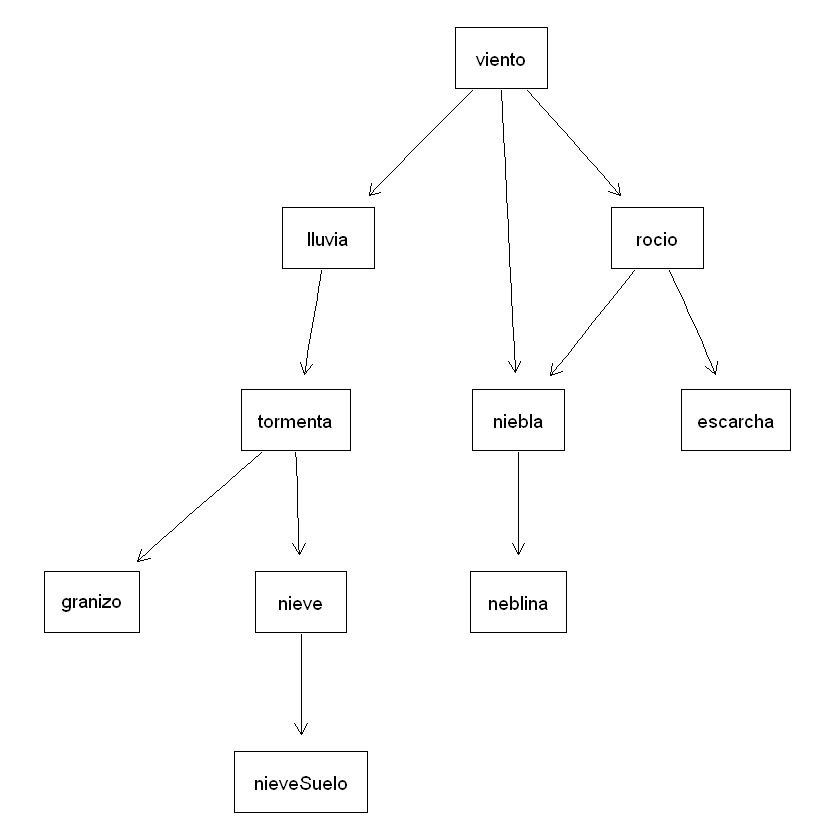

In [67]:
#grafos
graphviz.plot(dag)

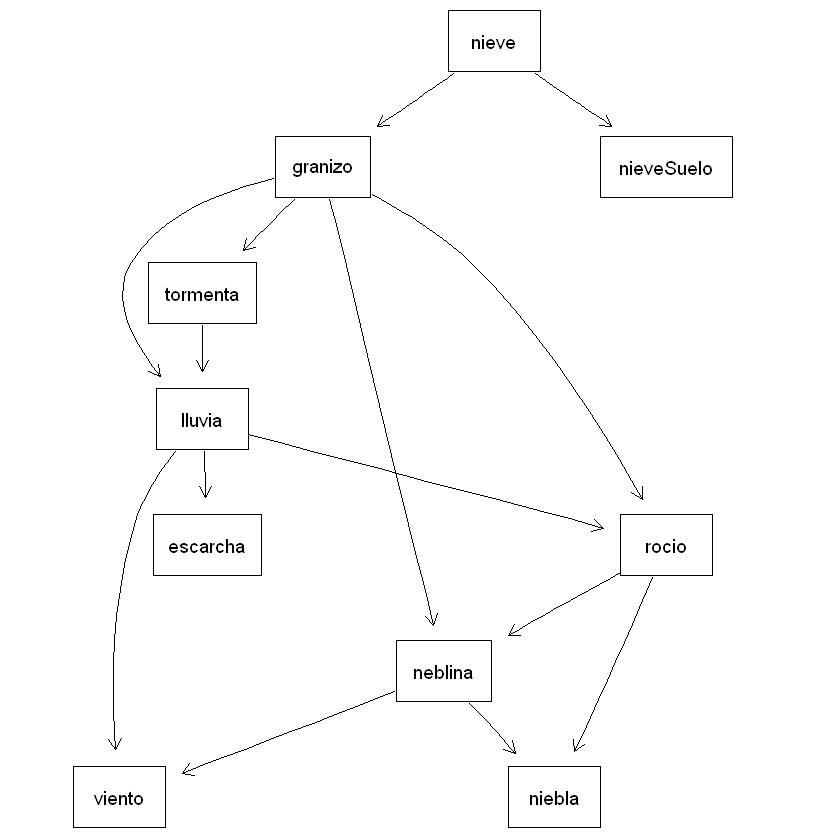

In [65]:
graphviz.plot(dag.hc)

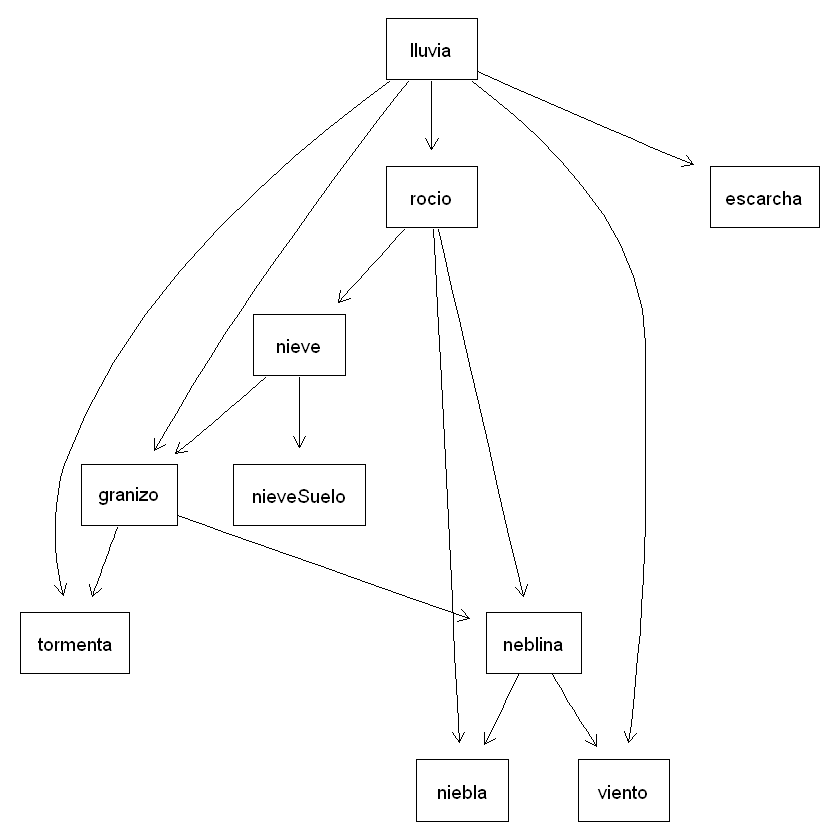

In [66]:
graphviz.plot(dag.tabu)

Me parece que las relaciones que muestra el grafo del experto son un poco más realistas que las que hay en los grafos aprendidos en términos de causalidad. En dag.hc, por ejemplo, el nodo raíz es nieve, lo que indica que la nieve tiene una influencia directa o indirecta sobre el resto de nodos y hay relaciones como nieve -> lluvia o nieve --> viento que entiendo que no tendrían por qué darse. Por otro lado, en dag.tabu rocio --> nieve no creo que sea una relación causal y, encambio, rocio --> escarcha sí debería serlo y no aparece.

In [69]:
#aprendizaje de dags con restricciones

#hc
whitelist <- matrix(c("viento", "lluvia", 'tormenta','granizo','nieve','nieveSuelo'),
                    ncol = 2, byrow = TRUE,
                    dimnames = list(NULL, c("from", "to")))
blacklist <- matrix(c('neblina','granizo','granizo','neblina','niebla','tormenta','tormenta','niebla'), 
                    ncol = 2, byrow = TRUE,
                    dimnames = list(NULL, c("from", "to")))

In [70]:
dag.hc.2 <- hc(df, whitelist = whitelist, blacklist = blacklist)

In [71]:
dag.tabu.2 <- tabu(df, whitelist = whitelist, blacklist = blacklist)

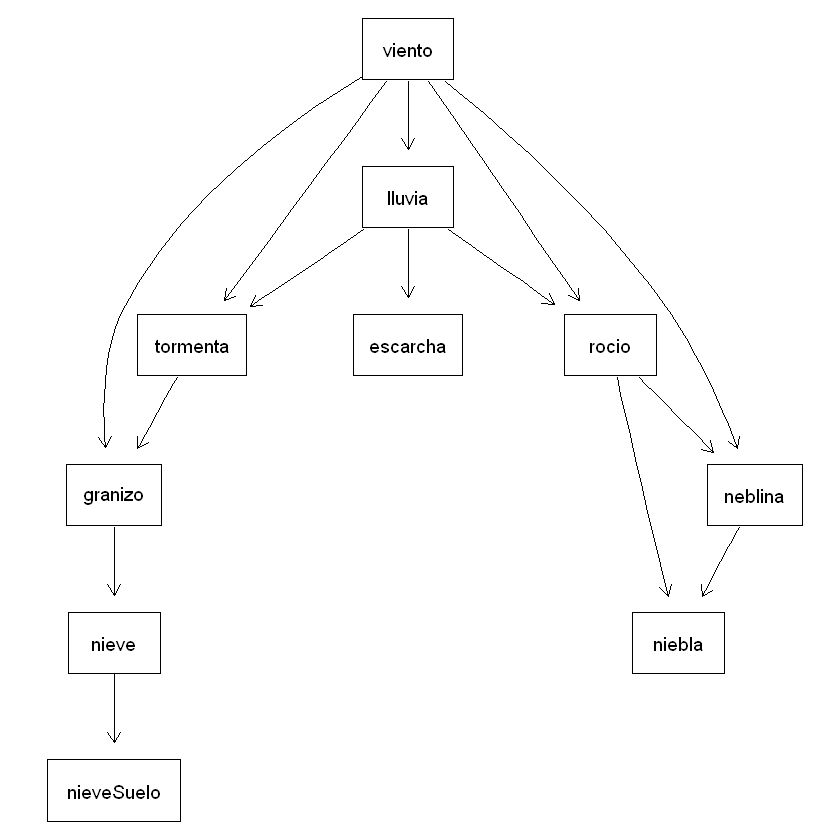

In [72]:
graphviz.plot(dag.hc.2)

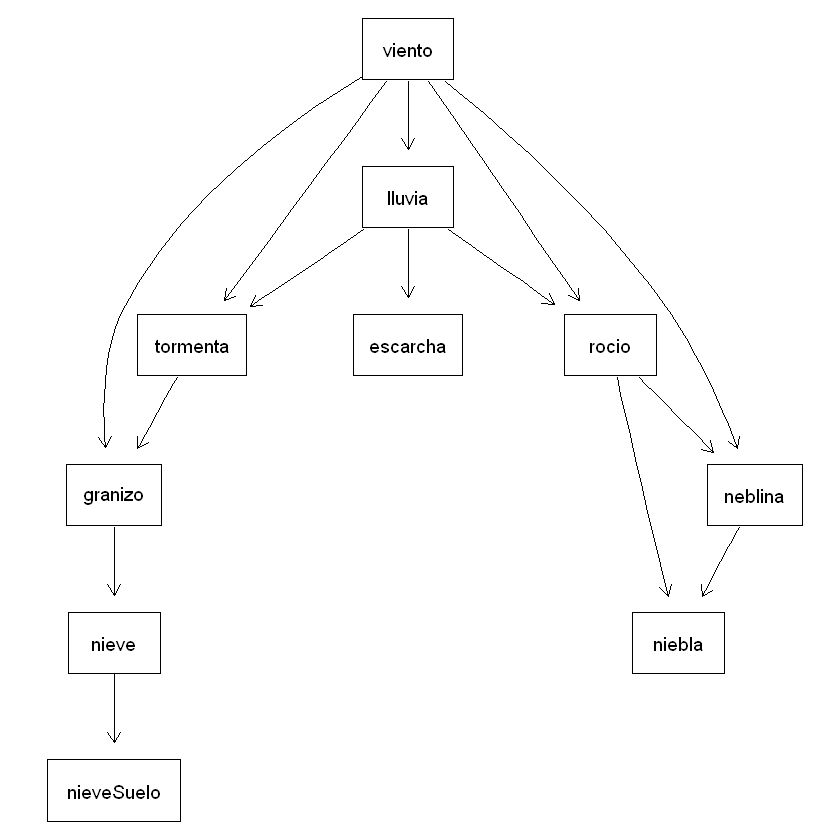

In [73]:
graphviz.plot(dag.tabu.2)

Vemos que ha cambiado la estructura de los grafos obtenidos por tabu y hill-climbing y que en este caso coinciden. A continuación calculamos el score global.

In [74]:
bic.tabu.2  <- bnlearn::score(dag.tabu.2, data = df, type = "bic")
bic.hc.2  <- bnlearn::score(dag.hc.2, data = df, type = "bic")

In [76]:
tablaBic2 <- tablaBic

In [79]:
tablaBic2[4,] = list('hc2', bic.hc.2)
tablaBic2[5,] = list('tabu2', bic.tabu.2)

In [81]:
#tabla ordenando por bic
tablaBic2[order(tablaBic2$BIC), ]

,algoritmo,BIC
,<chr>,<dbl>
1,experto,-9724.872
2,hc,-9366.750
3,tabu,-9365.175
4,hc2,-9361.871
5,tabu2,-9361.871


Vemos que los grafos que combinan el aprendizaje con el conocimiento a priori obtienen el mismo valor del BIC entre ellos y mejoran los resultados respecto a los grafos anteriores.

In [84]:
#fuerza de los arcos de los nuevos grafos. alpha = 0.05

#hc2 y tabu2 (mismo grafo)
f.arc.hc.2 <- arc.strength(dag.hc.2, data = df, criterion = "x2")
f.arc.hc.2 <- f.arc.hc.2[order(f.arc.hc.2$strength), ]
f.arc.hc.2

,from,to,strength
,<chr>,<chr>,<dbl>
3,nieve,nieveSuelo,2.515328e-101
4,lluvia,rocio,1.588620e-78
2,tormenta,granizo,1.375034e-67
1,viento,lluvia,5.887107e-48
5,rocio,neblina,9.575702e-44
8,viento,neblina,1.401866e-29
11,granizo,nieve,1.243591e-28
6,lluvia,tormenta,9.350705e-27
7,neblina,niebla,8.140958e-19


Vemos que todos los arcos del nuevo grafo representan una alta dependencia entre sus nodos.

In [87]:
summary(f.arc$strength)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 0.000e+00 0.000e+00 3.698e-06 0.000e+00 2.107e-05 

In [88]:
summary(f.arc.hc.2$strength)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 0.000e+00 0.000e+00 1.193e-07 3.653e-09 1.625e-06 

Además, vemos que de media los arcos del grafo que combina conocimiento con aprendizaje representan correlaciones algo más fuertes en comparación con el grafo dado por el experto.